In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
import os, sys
sys.path.append(os.path.abspath(".."))  # remonte d'un niveau depuis notebooks/

# Optionnel : pour vérifier que tu es bien à la racine
print("Contenu du répertoire courant :", os.listdir())

Contenu du répertoire courant : ['data_analysis.ipynb', 'study_found_art.ipynb', 'find_already_found.ipynb']


In [3]:
found_lostart = [589707, 589708, 614072, 526702, 567247, 429210]
found_mnr = ["MNR00246", "MNR00253", "MNR00181", "MNR00387", "MNR00386", "MNR00707"]

# 310418 NOT FOUND
# 600027 NOT FOUND
# 323038 NOT FOUND

Suppression à la main de toute mention de restitution dans la ligne Provenienz qui semble utile. 
Il y a aussi des mentions dans les lignes Inventarnummer/Signatur et Literatur/Quelle, mais ces lignes semblant moins utiles, je ne m'en suis pas préoccupé.

In [4]:
la = pd.read_csv("../data/found_lostart.csv")

to_keep = ["Lost Art ID", "Hersteller/Künstler/Autor:in", "Titel", "Datierung", "Objektart", "Beschreibung"]
lostarts = la[to_keep]
lostarts

,Lost Art ID,Hersteller/Künstler/Autor:in,Titel,Datierung,Objektart,Beschreibung
0,589707,"Unbekannt (Italienisch, Florenz) [Künstler:in]...",Einnahme von Karthago,1440 (um) [Datierung],Gemälde,Cassonemalerei; L'Assedio di Cartagine / Die B...
1,589708,"Ferrari, Defendente [Künstler:in]Unbekannt (It...",Marienbild,1490 (um) [Datierung],Gemälde,Madonna del LatteMadonna con BambiniLa Vierge ...
2,614072,"Courbet, Gustave (Kopie nach) [Künstler:in]",Vue d'Ornans / Ansicht von Ornans,NaN,Gemälde,NaN
3,526702,"Cleve, Cornelis van [Künstler:in]Cleve, Joos v...",Männliches Bildnis in schwarzem Mantel mit Pel...,1520 (um) [Datierung],Malerei,Männliches Bildnis in schwarzem Mantel mit Pel...
4,567247,"Patinir, Joachim [Künstler:in]Patinir, Joachim...",Flügelaltar,1520 (um) [Datierung],Malerei,"Quellen:Album Haus Bromberg, Nonnenstieg 9, Fa..."
5,429210,"Gael, Barend [Künstler:in]",Vor der Schenke,NaN,Malerei,"Vornehme Reiter mit Hunden rechts, links das W..."


In [5]:
from src.Embedding import EmbeddingFromPretrained
from sklearn.metrics.pairwise import cosine_similarity


def create_similarity_matrix(lostart, pop, embedder=EmbeddingFromPretrained().get_cls_embedding):
    embeddings = []
    for x in lostart:
        embs_x = []
        if type(x) == int:
            x = str(x)

        if not pd.notna(x):
            embs_x = [0] * len(pop)
        else:
            emb_x = embedder(x)
            for y in pop:
                if pd.notna(y):
                    emb_y = embedder(y)
                    embs_x.append(float(cosine_similarity(emb_x, emb_y)[0][0]))
                else:
                    embs_x.append(0)
        embeddings.append(embs_x)

    embeddings = np.array(embeddings)
    return embeddings

/Users/maximemoutet/.pyenv/versions/venv-nlp-ensae/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Mean embeddings shape: (5, 62)


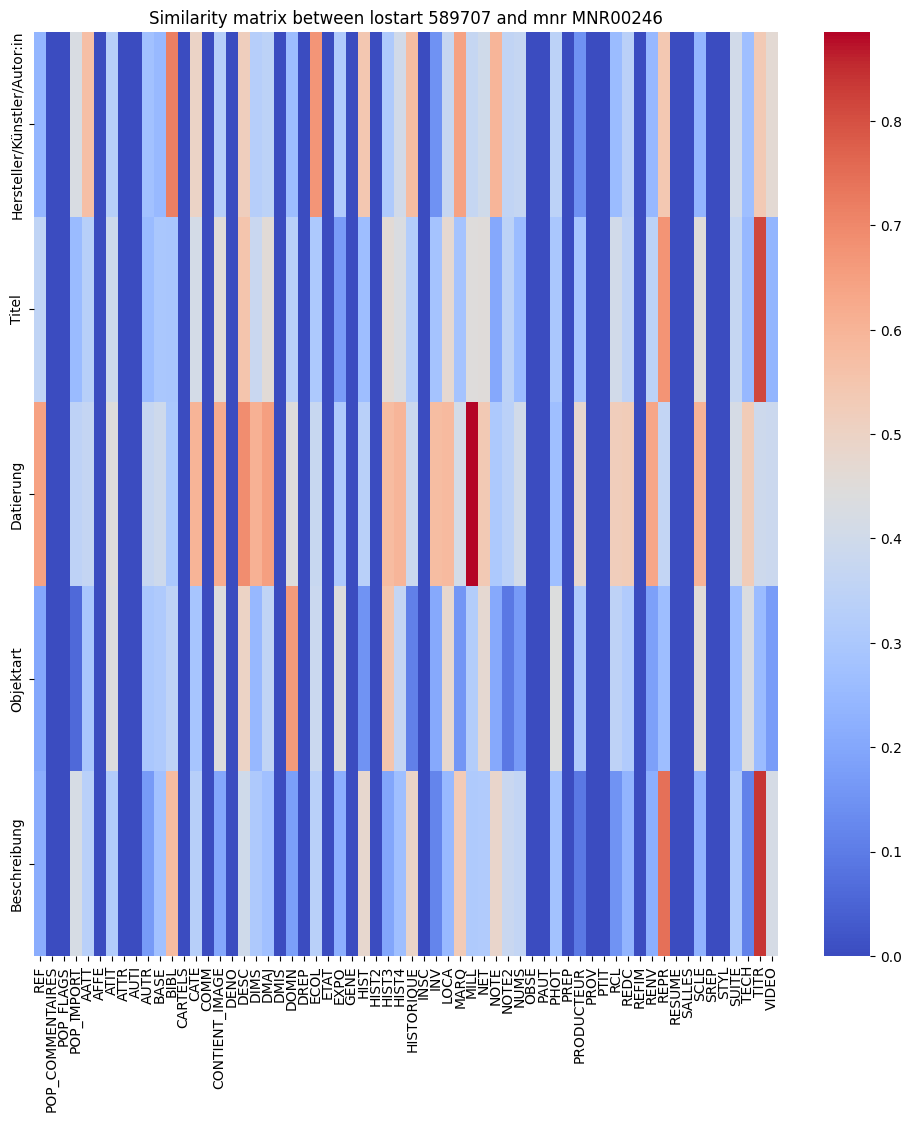

Saved similarity matrix for lostart 589707 and mnr MNR00246


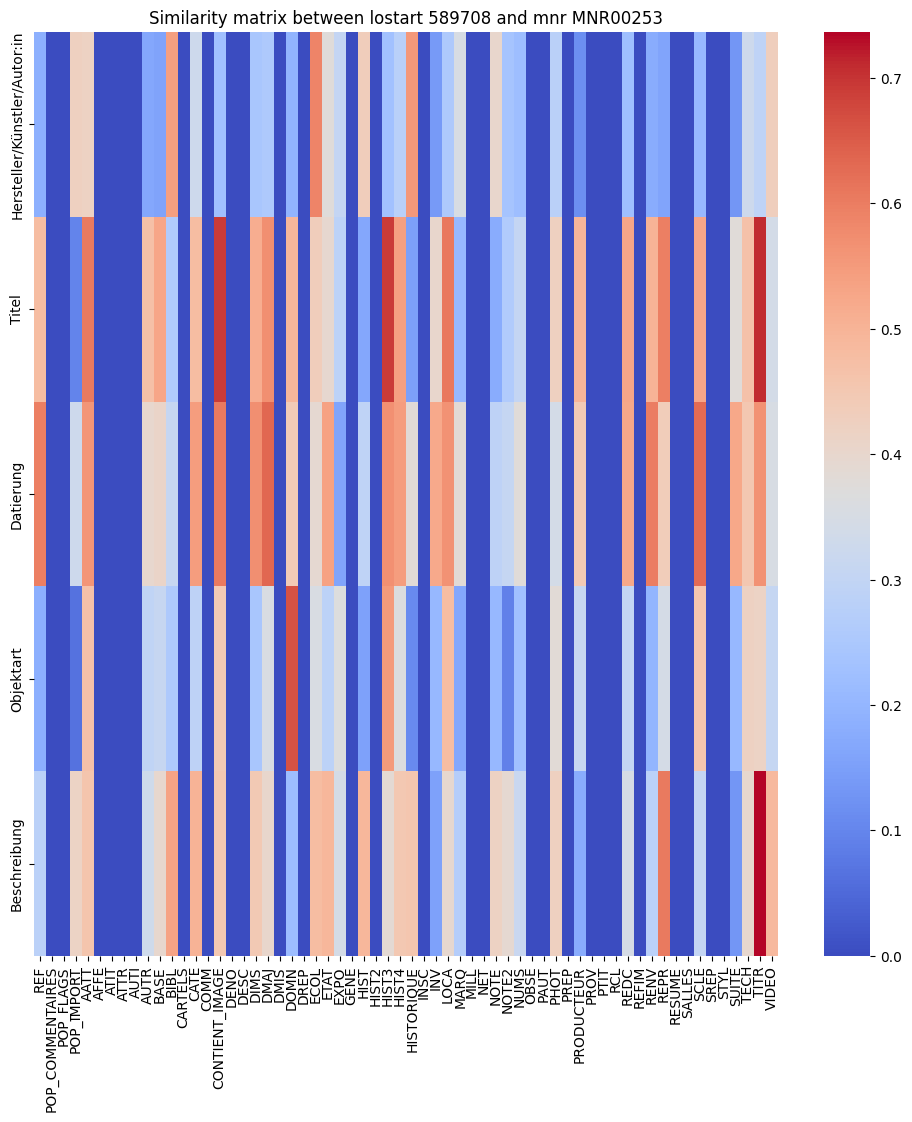

Saved similarity matrix for lostart 589708 and mnr MNR00253


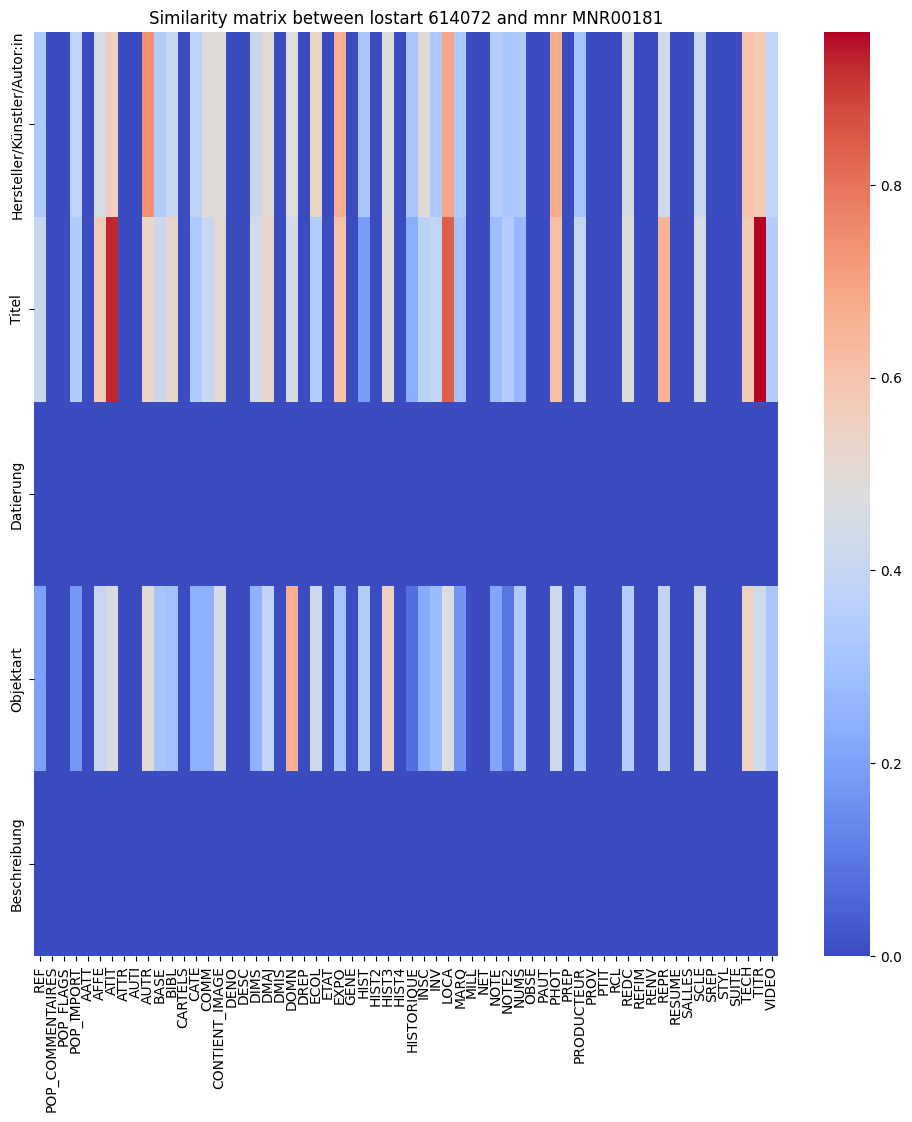

Saved similarity matrix for lostart 614072 and mnr MNR00181


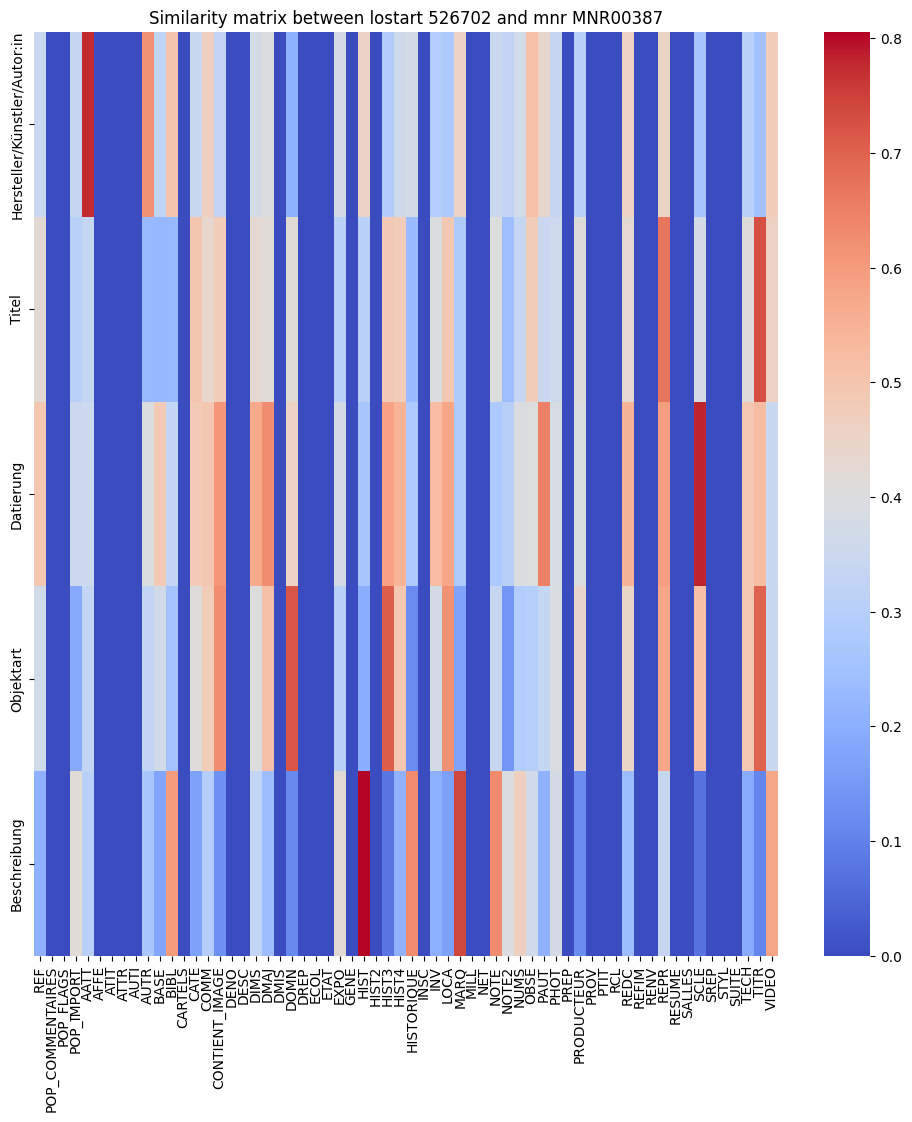

Saved similarity matrix for lostart 526702 and mnr MNR00387


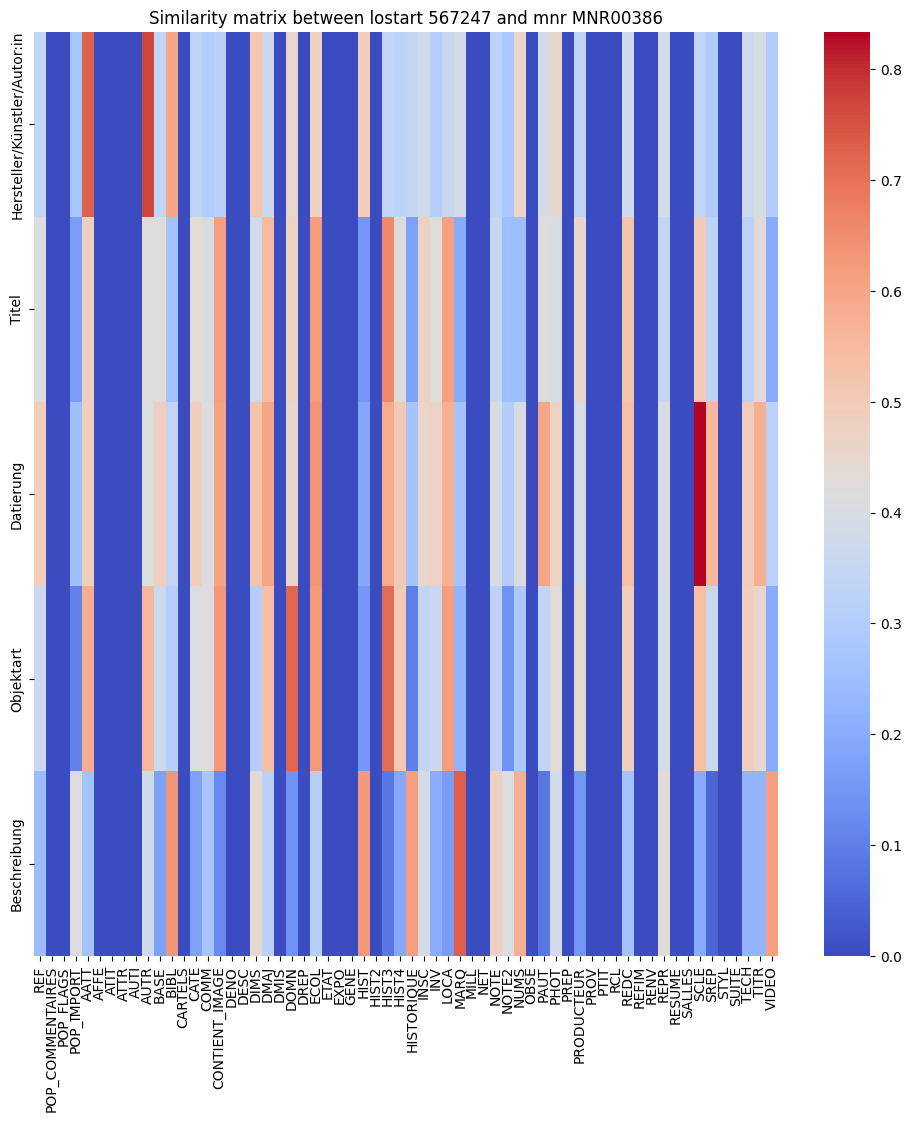

Saved similarity matrix for lostart 567247 and mnr MNR00386


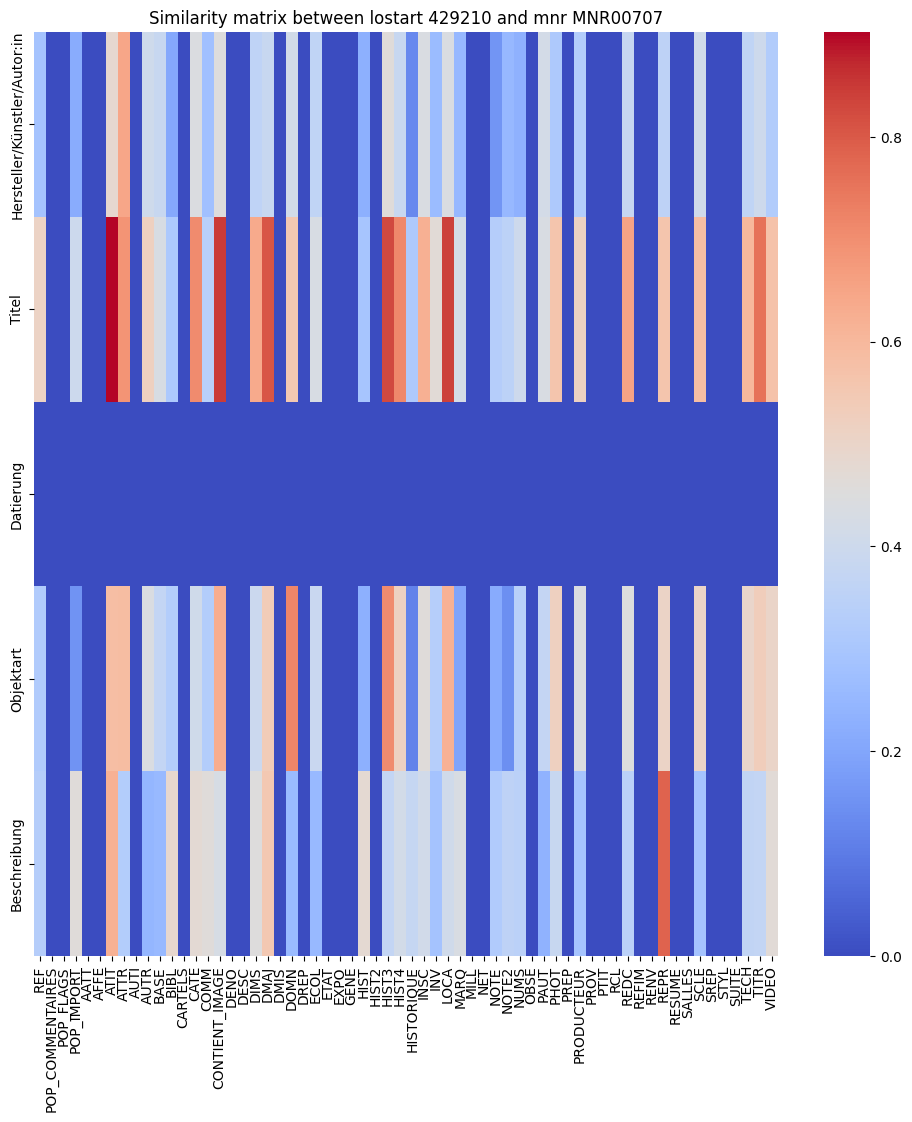

Saved similarity matrix for lostart 429210 and mnr MNR00707


Text(0.5, 1.0, 'Mean similarity matrix between lostarts and mnrs')

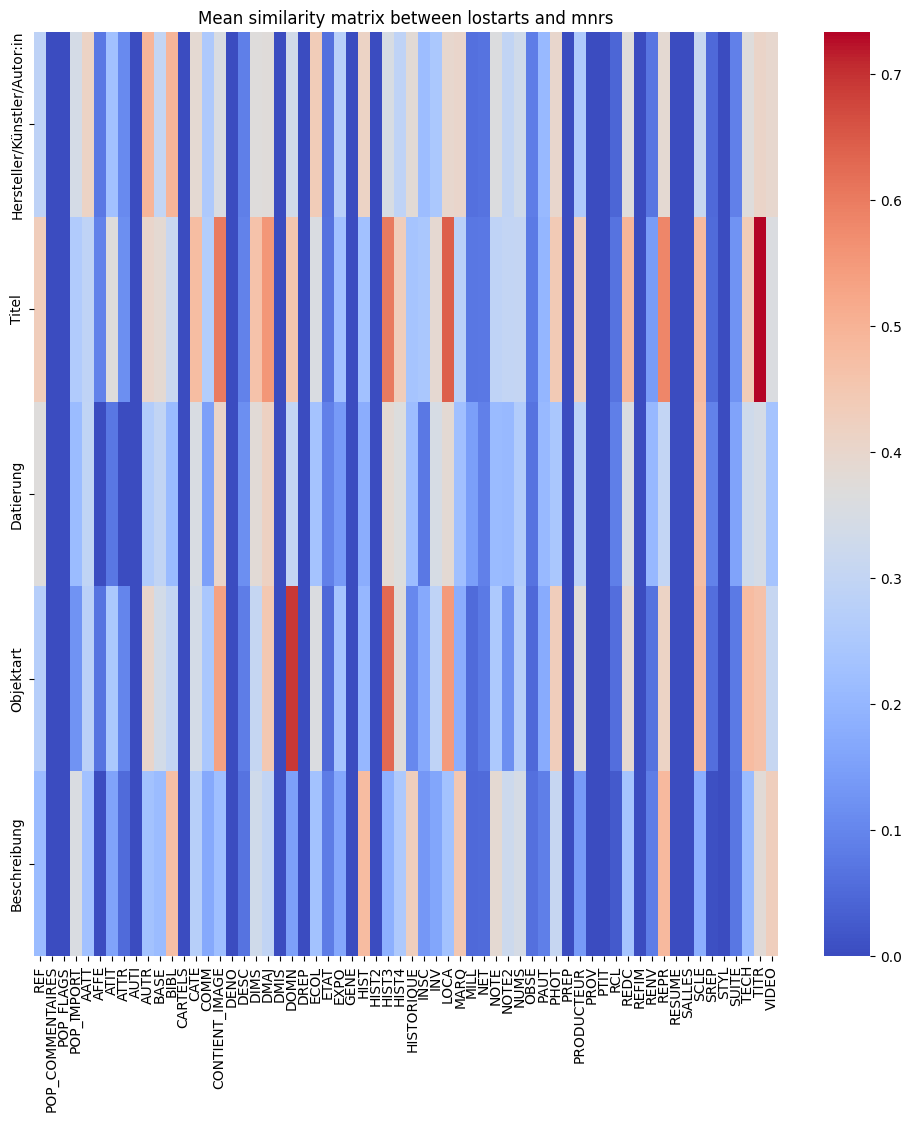

In [12]:
import seaborn as sns
from data.processing import find_pop

emb = "cls"
mean_embeddings = np.zeros((len(lostarts.columns)-1, 62))
print("Mean embeddings shape:", mean_embeddings.shape)

most_similar_combinations = []

for la, mnr in zip(found_lostart, found_mnr):
    lostart = lostarts[lostarts["Lost Art ID"] == la]
    lostart = lostart.drop(columns=["Lost Art ID"])
    pop = find_pop(mnr)

    embeddings = create_similarity_matrix(lostart.values[0], pop.values[0], embedder=EmbeddingFromPretrained().get_cls_embedding if emb == "cls" else EmbeddingFromPretrained().get_mean_pooling_embedding)

    mean_embeddings += embeddings

    # Get the 5 most similar combination
    most_similar_idx = np.unravel_index(np.argsort(embeddings.flatten())[-5:], embeddings.shape)
    most_similar_combinations.append(most_similar_idx)

    plt.figure(figsize=(12, 12))
    sns.heatmap(embeddings, annot=False, xticklabels=pop.columns, yticklabels=lostart.columns, cmap='coolwarm')
    plt.title(f"Similarity matrix between lostart {la} and mnr {mnr}")
    # plt.savefig(f"figures/similarities/RoBerta/{emb}/similarity_matrix_{la}_{mnr}_{emb}.png")
    plt.show()
    plt.close()
    print(f"Saved similarity matrix for lostart {la} and mnr {mnr}")

mean_embeddings /= len(found_lostart)

plt.figure(figsize=(12, 12))
sns.heatmap(mean_embeddings, annot=False, xticklabels=pop.columns, yticklabels=lostart.columns, cmap='coolwarm')
plt.title(f"Mean similarity matrix between lostarts and mnrs")
# plt.savefig(f"figures/similarities/RoBerta/{emb}/similarity_matrix_mean_{emb}.png")

In [13]:
most_similar_combinations

[(array([0, 4, 1, 4, 2]), array([11, 52, 60, 60, 36])),
 (array([3, 1, 1, 1, 4]), array([21, 29, 15, 60, 60])),
 (array([0, 0, 1, 1, 1]), array([34,  9, 34,  6, 60])),
 (array([1, 4, 0, 2, 4]), array([60, 35,  4, 55, 27])),
 (array([3, 0, 4, 0, 2]), array([21,  4, 35,  9, 55])),
 (array([1, 1, 1, 1, 1]), array([19, 29, 34, 15,  6]))]

In [20]:
most_important_cols = np.unique(np.array(most_similar_combinations)[:, 1].flatten())
print(most_important_cols)
print(pop.columns[most_important_cols])

[ 4  6  9 11 15 19 21 27 29 34 35 36 52 55 60]
Index(['AATT', 'ATIT', 'AUTR', 'BIBL', 'CONTIENT_IMAGE', 'DMAJ', 'DOMN',
       'HIST', 'HIST3', 'LOCA', 'MARQ', 'MILL', 'REPR', 'SCLE', 'TITR'],
      dtype='object')
